In [1]:
import warnings
warnings.filterwarnings('ignore')

### Импорт библиотек

In [2]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error

In [3]:
# Импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
# Импорт библиотеки кластеризации переменных
# https://pypi.org/project/varclushi/
! pip install varclushi
from varclushi import VarClusHi

## Загрузка данных

In [5]:
# Указываем путь к файлу
# При работе с google colab существует 2 варианта загрузки файла:
# 1. Через google drive
# 2. Через левое меню: "файлы" -> "загрузить в сессионное хранилище" -> "скопировать файл" (при наведении на файл)
file_path = 'white_wine.csv'

In [6]:
# Загружаем данные из SAS файла
df = pd.read_csv(file_path)
df = df.astype('float')
# Пример данных
df.head()

,fixed acidity,volatile acidity,citric acid,sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target_quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


## Функции обработки

In [7]:
# Метод главных компонент
def pca_transform(X, transform = []):
    pca_model = PCA(n_components='mle')
    pca_model.fit(X)

    if transform == []:
        transform = [X]
    return [pca_model.transform(t) for t in transform]

In [8]:
# Кластеризация переменных
def variable_clustering(X, transform = []):
    var_clust_model = VarClusHi(X, maxeigval2 = .7, maxclus = None)
    var_clust_model.varclus()
    var_clust = var_clust_model.rsquare.loc[:, ["Cluster","Variable","RS_Ratio"]]
    vars = var_clust.sort_values("RS_Ratio").drop_duplicates(['Cluster'],keep='first')["Variable"].to_list()

    if transform == []:
        transform = [X]
    return [t.loc[:, vars] for t in transform]

In [9]:
# Разделение на обучающую, валидационную и тестовую выборку
def data_partition(X, y):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, stratify = y, test_size=0.6, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, stratify = y_test_val, test_size=0.5, random_state=42)
    return (X_train, y_train, X_val, y_val, X_test, y_test)

In [10]:
# Расчет ошибки прогнозирования
def score_model_mae(model, 
                    X_train, y_train,
                    X_val, y_val,
                    X_test, y_test):
    print(model.__class__.__name__)
    print("TRAIN MSE: {:f}".format(mean_squared_error(y_train, model.predict(X_train))))
    print("VAL MSE: {:f}".format(mean_squared_error(y_val, model.predict(X_val))))
    print("TEST MSE: {:f}".format(mean_squared_error(y_test, model.predict(X_test))))

## Формирование признакового пространства

In [11]:
df.columns = df.columns.str.strip()

In [12]:
# Сформируем признаковое пространство:
# Целевая переменная: target_quality. Описывает субъективную оценку качества сорта вина. 
# Остальные переменные - входные. 
# Задача – спрогнозировать оценку эксперта в зависимости от объективных химических показателей вина и выявить важные признаки
y = df["target_quality"].to_frame()
X = df.loc[:, list(set(df.columns) - {"target_quality"})]

# Дискретизация отклика
qtransform = QuantileTransformer(output_distribution='normal', n_quantiles = 5, random_state = 42)
y.values[:] = qtransform.fit_transform(y)

## Часть 1: KNN

In [13]:
from sklearn.neighbors import KNeighborsRegressor

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

# Стандартизация
scaler = StandardScaler()
scaler.fit(X_train)
for X_ in (X_train, X_val, X_test):
    X_.values[:] = scaler.transform(X_)

# PCA или Variable clustring (вставьте свой код)
X_train, X_val, X_test = variable_clustering(X_train, [X_train, X_val, X_test])

# KNN 
knn = KNeighborsRegressor(n_neighbors=20)
knn.fit(X_train, y_train)

# Score
score_model_mae(knn, X_train, y_train, X_val, y_val, X_test, y_test)

KNeighborsRegressor
TRAIN MSE: 0.413794
VAL MSE: 0.450412
TEST MSE: 0.432806


### Вопросы части 1:

1. Какие значения MSE получились на тренировочном, валидационном и тестовом наборе данных?
2. Перед применением KNN вставьте предобработку PCA (Вариант I), Variable clustering (Вариант II). 
3. Сколько переменных теперь передается на вход KNN? Как изменились значения MSE в результате? Почему это могло произойти?

### Ответы к части 1

1. Без предобработки:\
MSE на тренирочном наборе 0.385404\
MSE на валидационном наборе 0.441951\
MSE на тестовом наборе 0.402548

2. С предобработкой (Variable clustering):\
MSE на тренировочном наборе 0.413794\
MSE на валидационном наборе 0.450412\
MSE на тестовом наборе 0.432806

3. На вход KNN теперь передаётся 7 переменных вместо 11. В результате все три значения MSE увеличились. Это могло произойти из-за снижения сложности модели (недообучения).

In [14]:
X_train.columns

Index(['chlorides', 'sulphates', 'citric acid', 'volatile acidity', 'density',
       'free sulfur dioxide', 'pH'],
      dtype='object')

## Часть 2: Regression

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
import statsmodels.api as sm
# Документация для OLS
# https://bookdown.org/mike/data_analysis/ordinary-least-squares.html

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

# MinMax стандартизация (вставьте свой код)
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

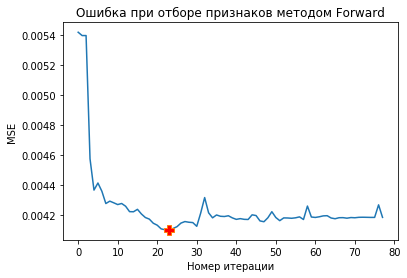

LinearRegression
TRAIN MSE: 0.003595
VAL MSE: 0.004101
TEST MSE: 0.003680


In [24]:
# Построим полиномиальную регрессию (degree = 2)

# Отобразмим пространство признаков в пространство полиномов степени 2
poly_reg = PolynomialFeatures(degree=2)
X_train = poly_reg.fit_transform(X_train)
X_val = poly_reg.transform(X_val)
X_test = poly_reg.transform(X_test)

# Определим лучшее число признаков с помощью Forward
best_feats = None
features = []
errs = []
all_feats = set(range(X_train.shape[1]))
step = 0
min_step = 0
while len(features) < len(all_feats):
    step += 1
    new_errs = []
    new_feat = -1
    pvalues = []
    for feat in (all_feats - set(features)):
        model = sm.OLS(y_train, X_train[:, features + [feat]])
        res = model.fit()
        pvalue = res.pvalues[-1]
        pvalues.append(pvalue)
        if min(pvalues) == pvalue:
            new_feat = feat
    # Выбираем лучший признак (с минимальным pvalue) и добавляем к пространству признаков
    features.append(new_feat)

    lr = LinearRegression()
    lr.fit(X_train[:, features], y_train)
    err = mean_squared_error(y_val, lr.predict(X_val[:, features]))
    errs.append(err)
    if min(errs) == err:
        best_feats = features.copy()
        min_step = step

# Визуализируем ошибки
idx = len(best_feats) - 1
plt.plot(errs)
plt.plot(idx, errs[idx], 'P', ms=10, mfc='red')
plt.xlabel("Номер итерации")
plt.ylabel("MSE")
plt.title("Ошибка при отборе признаков методом Forward")
plt.show()

# Обучим линейную регрессию на лучших признаках
lr = LinearRegression()
lr.fit(X_train[:, best_feats], y_train)

score_model_mae(lr, 
                X_train[:, best_feats], y_train, 
                X_val[:, best_feats], y_val, 
                X_test[:, best_feats], y_test)

### Вопросы к части 2:

1. Аналогично алгоритму выбора признаков Backward, опишите алгоритм Forward
2. Какая модель показывает лучшее качество на тестовом наборе? 
3. Какие переменные не вошли в результирующую регрессионую модель? 
4. На каком шаге была выбрана лучшая модель?
5. С помощью summary() определите какая из вошедших переменных наименее важная с точки зрения t-статистики?

5. После разделения данных добавьте MinMaxScaler. Как изменились результаты регрессионной модели с точки числа степеней свободы и значения MSE на тестовом наборе?

### Ответы к части 2

1. Ошибки на алгоритме Backward:\
TRAIN MSE: 0.374462\
VAL MSE: 0.450904\
TEST MSE: 0.390574\
Алгоритм Forward реализован выше.

2. Ошибки на алгоритме Forward:\
TRAIN MSE: 0.427862\
VAL MSE: 0.441393\
TEST MSE: 0.430660\
На тестовом наборе лучшее качество показывает модель Backward.

In [170]:
# 3. В результирующую модель вошли следующие переменные:
best_feats

[57, 70, 6, 73, 72, 68, 14]

In [174]:
# Соответственно, НЕ вошли переменные
np.array(all_feats - set(best_feats))

array({0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 71, 74, 75, 76, 77},
      dtype=object)

In [178]:
# 4. Номер шага, на котором была выбрана лучшая модель
min_step

7

In [17]:
# 5. Наименее важна первая переменная x1, так как её значение t-статистики наибольшее по модулю.
model = sm.OLS(y_train, X_train[:, best_feats])
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         target_quality   R-squared (uncentered):                   0.286
Model:                            OLS   Adj. R-squared (uncentered):              0.283
Method:                 Least Squares   F-statistic:                              111.6
Date:                Wed, 13 Apr 2022   Prob (F-statistic):                   8.96e-138
Time:                        15:43:13   Log-Likelihood:                         -1948.7
No. Observations:                1959   AIC:                                      3911.
Df Residuals:                    1952   BIC:                                      3950.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0240      0.001     16.992      0.000       0.021       0.027
x2            -0.5211      0.051    -10.191      0.000      -0.621      -0.421
x3            -0.2213      0.019    -11.694      0.000      -0.258      -0.184
x4             0.0031      0.000      9.380      0.000       0.002       0.004
x5            -0.0002   2.55e-05     -7.734      0.000      -0.000      -0.000
x6             2.4719      0.502      4.923      0.000       1.487       3.457
x7             0.0261      0.006      4.229      0.000       0.014       0.038
==============================================================================
Omnibus:                      848.999   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19961.356
Skew:                          -1.492   Prob(JB):                         0.00
Kurtosis:                      18.351   Cond. No.                     7.37e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Результаты после добавления MinMaxScaler:\
TRAIN MSE: 0.003595\
VAL MSE: 0.004101\
TEST MSE: 0.003680\
Все значения MSE уменьшились на два порядка. Число вошедших переменных (то есть степеней свободы) теперь равно 23.

In [25]:
model = sm.OLS(y_train, X_train[:, best_feats])
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     42.90
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          1.68e-154
Time:                        15:57:19   Log-Likelihood:                 2733.1
No. Observations:                1959   AIC:                            -5418.
Df Residuals:                    1935   BIC:                            -5284.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0651      0.083     -0.788      0.431      -0.227       0.097
x2             0.0978      0.110      0.886      0.376      -0.119       0.314
const          0.5012      0.018     27.991      0.000       0.466       0.536
x3            -0.0530      0.031     -1.722      0.085      -0.113       0.007
x4            -0.2707      0.051     -5.286      0.000      -0.371      -0.170
x5             0.2500      0.119      2.108      0.035       0.017       0.483
x6             1.0323      0.142      7.271      0.000       0.754       1.311
x7            -1.2165      0.195     -6.228      0.000      -1.600      -0.833
x8             0.0081      0.090      0.090      0.929      -0.169       0.185
x9            -1.5725      0.209     -7.542      0.000      -1.981      -1.164
x10            0.1242      0.092      1.349      0.177      -0.056       0.305
x11            1.5101      0.256      5.896      0.000       1.008       2.012
x12           -0.1004      0.139     -0.721      0.471      -0.373       0.173
x13            0.3205      0.068      4.694      0.000       0.187       0.454
x14           -0.3339      0.112     -2.979      0.003      -0.554      -0.114
x15            2.5031      0.388      6.457      0.000       1.743       3.263
x16            0.1294      0.041      3.166      0.002       0.049       0.210
x17           -0.8928      0.205     -4.360      0.000      -1.294      -0.491
x18            0.5330      0.092      5.807      0.000       0.353       0.713
x19           -1.4628      0.311     -4.709      0.000      -2.072      -0.854
x20           -0.2545      0.078     -3.262      0.001      -0.407      -0.101
x21            0.2316      0.070      3.301      0.001       0.094       0.369
x22           -0.8684      0.273     -3.178      0.002      -1.404      -0.333
x23            0.0804      0.033      2.411      0.016       0.015       0.146
==============================================================================
Omnibus:                      808.553   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17673.489
Skew:                          -1.413   Prob(JB):                         0.00
Kurtosis:                      17.441   Cond. No.                         452.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Часть 3: PLS/PCR

In [42]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

# Метод PCR представляем в виде комбинации PCA с последующей линейной регрессией
pcr = make_pipeline(PCA(n_components=5), LinearRegression())
pcr.fit(X_train, y_train)

pls = PLSRegression(n_components=5)
pls.fit(X_train, y_train)

# MSE
score_model_mae(pcr, X_train, y_train, X_val, y_val, X_test, y_test)
score_model_mae(pls, X_train, y_train, X_val, y_val, X_test, y_test)

Pipeline
TRAIN MSE: 0.477364
VAL MSE: 0.496493
TEST MSE: 0.471302
PLSRegression
TRAIN MSE: 0.441024
VAL MSE: 0.464150
TEST MSE: 0.445547


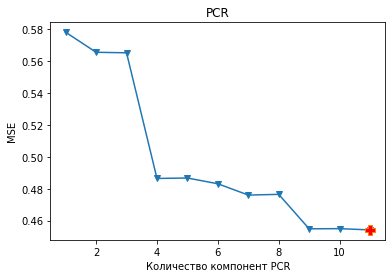

In [50]:
# Необходимо определить лучшее количество компонент

def optimise_comp_cv(X, y, n_comp):
    # Определяем модель (PLS или PCR)
    pcr = make_pipeline(PCA(n_components=n_comp), LinearRegression())
    # pls = PLSRegression(n_components=n_comp)

    # Расчет ошибки на кросс-валидации
    y_cv = cross_val_predict(pcr, X, y, cv=10)
    mse = mean_squared_error(y, y_cv)
    return mse

# Визуализация MSE
def plot_metrics(vals, ylabel, objective, xticks):
    plt.plot(xticks, np.array(vals), '-v')
    if objective=='min':
        idx = np.argmin(vals)
    else:
        idx = np.argmax(vals)
    plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

    plt.xlabel('Количество компонент PCR')
    plt.xticks = xticks
    plt.ylabel(ylabel)
    plt.title('PCR')
    plt.show()


# Кросс-валидация проводится на обучающей и валидационной выборках
X_tr_val = pd.concat([X_train, X_val])
y_tr_val = pd.concat([y_train, y_val])
mses = []
list_components = list(range(1, X_tr_val.shape[1]+1))
for n_comp in list_components:
    mse = optimise_comp_cv(X_tr_val, y_tr_val, n_comp)
    mses.append(mse)
plot_metrics(mses, 'MSE', 'min', list_components)

In [49]:
pls = PLSRegression(n_components=6)
pls.fit(X_tr_val, y_tr_val)
y_pred = pls.predict(X_test)
mean_squared_error(y_test, y_pred)

0.43912085131131584

In [51]:
pcr = make_pipeline(PCA(n_components=11), LinearRegression())
pcr.fit(X_tr_val, y_tr_val)
y_pred = pcr.predict(X_test)
mean_squared_error(y_test, y_pred)

0.4382694304803226

### Вопросы к части 3:

1. Сколько компонент было выбрано для моделей PCR и PLS?
2. Какое значение MSE модели показывают на тестовом наборе?

### Ответы к части 3

1. Для модели PLS выбрано 6 компонент, для модели PCR - 11.

2. Для модели PLS значение MSE на тестовом наборе равно примерно 0.439. Для модели PCR - 0.438.

## Часть 4: LARS + LASSO

In [52]:
# Документация LARS+LASSO
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsIC.html#sklearn.linear_model.LassoLarsIC

from sklearn.linear_model import LassoLarsIC

X_train, y_train, X_val, y_val, X_test, y_test = data_partition(X, y)

X_tr_val = pd.concat([X_train, X_val])
y_tr_val = pd.concat([y_train, y_val])
reg = LassoLarsIC(criterion='aic', normalize=True)
reg.fit(X_tr_val, y_tr_val)

score_model_mae(reg, X_train, y_train, X_val, y_val, X_test, y_test)

LassoLarsIC
TRAIN MSE: 0.440585
VAL MSE: 0.456414
TEST MSE: 0.438269


### Вопросы к части 4:

1. Какое значение MSE модель показывает на тестовом наборе? 
2. Какая пременная была отобрана на первом шаге? 
3. Сколько всего переменных было отобрано?
4. Если бы вместо критерия отбора модели вашего варианта использовался критерий MSE на валидационном наборе, то было бы отобрано больше или меньше переменных?

### Ответы к части 4

1. На тестовом наборе значение MSE равно 0.438269.

In [71]:
reg = LassoLarsIC(criterion='aic', normalize=True, max_iter=1)
reg.fit(X_tr_val, y_tr_val)
reg.coef_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.10976472, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

2. На первом шаге отобрана 6-я переменная из 11, то есть 'alcohol'.

In [73]:
reg = LassoLarsIC(criterion='aic', normalize=True)
reg.fit(X_tr_val, y_tr_val)
reg.coef_

array([ 5.30345043e-02,  6.43873978e-02, -1.12478903e+02,  3.32400093e-03,
       -4.37833770e-04,  1.61318200e-01,  3.86450539e-02,  5.67321205e-01,
        3.73576798e-01,  5.73314263e-01, -1.63358770e+00])

3. Отобраны все 11 переменных (в массиве reg.coef_ все элементы ненулевые).

## Общие вопросы:

1. Зачем при разделении выборкок проводится стратификация по целевой переменной?
2. Какая модель показала лучшее значение MSE на тестовой выборке?